## Load data & set configuration

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy

def fix_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    numpy.random.seed(seed)

fix_seed(2021)

config = {
    "batch_size": 100,
    "learning_rate": 0.008,
    "epochs": 10,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
}

transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(
    root='./cifar10', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=config['batch_size'], shuffle=True)

testset = torchvision.datasets.CIFAR10(
    root='./cifar10', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=config['batch_size'], shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


## Preveiw photos

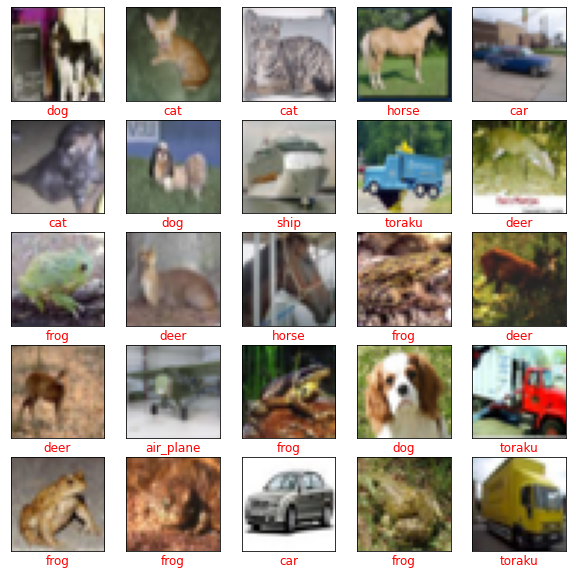

In [2]:
class_names = ['air_plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'toraku']

# get some random training images

plt.figure(figsize=(10, 10))
counter = 0
for images, labels in trainloader:
    for i, img in enumerate(images):
        plt.subplot(5, 5, counter+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img = img/2 + 0.5   # unmornalize
        # convert (C,H,W) to (H,W,C)
        img_show = numpy.transpose(img, (1, 2, 0))
        plt.imshow(img_show, cmap=plt.cm.binary)
        plt.xlabel(class_names[int(labels[i])], color='red', fontsize='large')
        counter += 1
        if counter == 25:
            break
    if counter == 25:
        break

plt.show()


## Build Model

In [3]:
class MyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, 3)
        self.batch1 = torch.nn.BatchNorm2d(32)
        self.conv2 = torch.nn.Conv2d(32, 64, 3)
        self.batch2 = torch.nn.BatchNorm2d(64)
        self.conv3 = torch.nn.Conv2d(64, 128, 2)
        self.batch3 = torch.nn.BatchNorm2d(128)
        self.conv4 = torch.nn.Conv2d(128, 256, 2)
        self.batch4 = torch.nn.BatchNorm2d(256)
        self.conv5 = torch.nn.Conv2d(256, 512, 2)
        self.batch5 = torch.nn.BatchNorm2d(512)
        self.maxpooling = torch.nn.MaxPool2d(2)
        self.relu = torch.nn.ReLU()
        self.flatten = torch.nn.Flatten()
        self.linear1 = torch.nn.Linear(12800, 1024)
        self.linear2 = torch.nn.Linear(1024, 10)
        self.dropout = torch.nn.Dropout(.2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.batch2(x)
        x = self.maxpooling(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.batch3(x)
        x = self.relu(x)

        x = self.conv4(x)
        x = self.batch4(x)
        x = self.relu(x)

        x = self.conv5(x)
        x = self.batch5(x)
        x = self.maxpooling(x)
        x = self.relu(x)

        x = self.flatten(x)
        x = self.linear1(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x


In [4]:
def compile(model, train_loader, test_loader, input_shape, epochs, optimizer, loss):
    train_acc = []
    train_loss = []
    test_acc = []
    test_loss = []
    for epoch in range(epochs):
        ###############################################################
        num_train = 0
        num_correct_train = 0
        print("\repoch", epoch+1)
        for (xList, yList) in train_loader:
            xList, yList = torch.autograd.Variable(
                xList), torch.autograd.Variable(yList)
            optimizer.zero_grad()

            if torch.cuda.is_available():
                xList = xList.type(torch.cuda.FloatTensor)
                yList = yList.type(torch.cuda.LongTensor)
                device = torch.device(
                    "cuda:0" if torch.cuda.is_available() else "cpu")
                model.to(device)

            outputs = model(xList)
            train_loss_func = loss(outputs, yList)
            train_loss_func.backward()
            optimizer.step()

            num_train += len(yList)  # i.e., add bath size

            # torch.max() return a list where list[0]: val list[1]: index
            predicts = torch.max(outputs.data, 1)[1]
            num_correct_train += (predicts == yList).float().sum()
            
            
            print('\r %d ...' % num_train, end='')
        
        train_acc.append(num_correct_train / num_train)
        train_loss.append(train_loss_func.data)
        print("\r    - train_acc %.5f train_loss %.5f" %
                  (train_acc[-1], train_loss[-1]))

        ###############################################################
        num_test = 0
        num_correct_test = 0
        for (xList, yList) in test_loader:
            if torch.cuda.is_available():
                xList = xList.type(torch.cuda.FloatTensor)
                yList = yList.type(torch.cuda.LongTensor)
                device = torch.device(
                    "cuda:0" if torch.cuda.is_available() else "cpu")
                model.to(device)
            
            outputs = model(xList)
            test_loss_func = loss(outputs, yList)

            num_test += len(yList)
            predicts = torch.max(outputs.data, 1)[1]
            num_correct_test += (predicts == yList).float().sum()

        test_acc.append(num_correct_test / num_test)
        test_loss.append(test_loss_func.data)
        print("\r    - test_acc  %.5f test_loss  %.5f" %
                (test_acc[-1], test_loss[-1]))
    return train_loss, train_acc, test_loss, test_acc


## Training

In [5]:
model = MyModel()
loss = torch.nn.CrossEntropyLoss()

result = compile(model, trainloader, testloader, (-1, 3, 32, 32), config["epochs"], optimizer=torch.optim.Adam(
    model.parameters(), lr=config["learning_rate"]), loss=loss)


epoch 1


C:\Python38\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


    - train_acc 0.28500 train_loss 1.80702
    - test_acc  0.39370 test_loss  1.57762
epoch 2
    - train_acc 0.42954 train_loss 1.46578
    - test_acc  0.45630 test_loss  1.48761
epoch 3
    - train_acc 0.48602 train_loss 1.39062
    - test_acc  0.49660 test_loss  1.49736
epoch 4
    - train_acc 0.52688 train_loss 1.36411
    - test_acc  0.52410 test_loss  1.30778
epoch 5
    - train_acc 0.56078 train_loss 1.29610
    - test_acc  0.59000 test_loss  1.14340
epoch 6
    - train_acc 0.59676 train_loss 1.11111
    - test_acc  0.61850 test_loss  1.03030
epoch 7
    - train_acc 0.63122 train_loss 1.00394
    - test_acc  0.61490 test_loss  1.13969
epoch 8
    - train_acc 0.65690 train_loss 0.97223
    - test_acc  0.64250 test_loss  0.99235
epoch 9
    - train_acc 0.68268 train_loss 1.04087
    - test_acc  0.68060 test_loss  0.76338
epoch 10
    - train_acc 0.70626 train_loss 1.02059
    - test_acc  0.69520 test_loss  0.80124


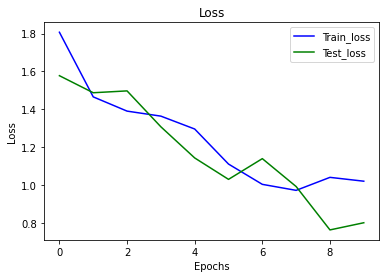

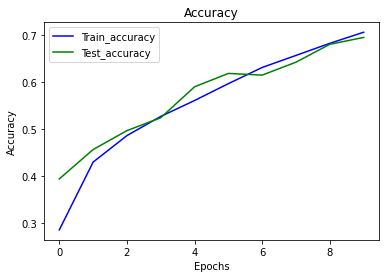

In [6]:
# visualization
(train_loss, train_acc, test_loss, test_acc) = result
plt.plot(range(config["epochs"]), train_loss, 'b-', label='Train_loss')
plt.plot(range(config["epochs"]), test_loss, 'g-', label='Test_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.plot(range(config["epochs"]), train_acc, 'b-', label='Train_accuracy')
plt.plot(range(config["epochs"]), test_acc, 'g-', label='Test_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
